# <div align="center">Word2vec from Scratch with NumPy</div>
---------------------------------------------------------------------

you can Find me on Github:
> ###### [ GitHub](https://github.com/lev1khachatryan)

# <div align="center">Introduction</div>
---------------------------------------------------------------------

Recently, I have been working with several projects related to NLP at work. Some of them had something to do with training the company’s in-house word embedding. At work, the tasks were mostly done with the help of a Python library: gensim. However, I decided to implement a Word2vec model from scratch just with the help of Python and NumPy because reinventing the wheel is usually an awesome way to learn something deeply.

# <div align="center">Word Embedding</div>
---------------------------------------------------------------------

Word embedding is nothing fancy but methods to represent words in a numerical way. More specifically, methods to map vocabularies to vectors.

The most straightforward method could be using one-hot encoding to map each word to a one-hot vector.

Although one-hot encoding is quite simple, there are several downsides. The most notable one is that it is not easy to measure relationships between words in a mathematical way.

Word2vec is a neural network structure to generate word embedding by training the model on a supervised classification problem. Such a method was first introduced in the paper Efficient Estimation of Word Representations in Vector Space by Mikolov et al.,2013 and was proven to be quite successful in achieving word embedding that could used to measure syntactic and semantic similarities between words.

# <div align="center">Word2vec (Skip-gram)</div>
---------------------------------------------------------------------

In Mikolov et al.,2013, two model architectures were presented, Continuous Bag-of-Words model and Skip-gram model. I will be diving into the latter in this article.

In order to explain the skip-gram model, I randomly quote a piece of text from a book that I am currently reading, The Little Book of Common Sense Investing by John Bogle:

***After the deduction of the costs of investing, beating the stock market is a loser’s game.***

As I have mentioned above, it is a supervised classification problem that the word2vec model tries to optimize. More specifically, given a ***“context word”***, we want to train a model such that the model can predict a ***“target word”***, one of the words appeared within a predefined window size from the context word.

<img src='asset/5/1.jpg'>

Take the above sentence for example, given a context word “investing” and a window size of 5, we would like the model to generate one of the underlying words. (one of the words in ***deduction, of, the costs, beating, stock, market, is*** in the case.)

# <div align="center">Model Overview</div>
---------------------------------------------------------------------

The following shows the original diagram presented in the paper by Mikolov et al.,2013.

<img src='asset/5/2.png'>

I made another graph with a little bit more details

<img src='asset/5/3.jpg'>

The word embedding layer is essentially a matrix with a shape of (# of unique words in the corpus, word embedding size). Each row of the matrix represent a word in the corpus. Word embedding size is a hyper-parameter to be decided and can be thought as how many features that we would like to use to represent each word. The latter part of the model is simply a logistic regression in a neural network form.

In the training process, the word embedding layer and the dense layer are being trained such that the model is able to predict target words given a context word at the end of the training process. After training such a model with a huge amount of data, the word embedding layer will end up becoming a representation of words which could demonstrate many kinds of cool relationships between words in a mathematical way. (Those who are interested in more details can refer to the original paper.)

# <div align="center">Implementation from Scratch with Python</div>
---------------------------------------------------------------------

To generate training data, we tokenize text first. There are many techniques out there when it comes to tokenize text data, such as getting rid of words appearing in very high or very low frequency. I just split the text with a simple regex since the focus of the article is not tokenization.

Next, we assign an integer to each word as its id. In addition, using word_to_id and id_to_word to record the mapping relationships.

Eventually, we generate training data for the model. For each context word tokens[i], generate: (tokens[i], tokens[i-window_size]), ..., (tokens[i], tokens[i-1]), (tokens[i], tokens[i+1]), ..., (tokens[i], tokens[i+window_size]). Take context word investing with a window size of 5 for example, we will generate(investing, deduction), (investing, of), (investing, the), (investing, costs), (investing, of), (investing, beating), (investing, the), (investing, stock), (investing, market), (investing, is) . Note: In the code, the training (x, y) pairs are represented in word ids.

The follow is the code for generating training data:

In [14]:
import re
import numpy as np


def tokenize(text):
    # obtains tokens with a least 1 alphabet
    pattern = re.compile(r'[A-Za-z]+[\w^\']*|[\w^\']*[A-Za-z]+[\w^\']*')
    return pattern.findall(text.lower())

def mapping(tokens):
    word_to_id = dict()
    id_to_word = dict()

    for i, token in enumerate(set(tokens)):
        word_to_id[token] = i
        id_to_word[i] = token

    return word_to_id, id_to_word

def generate_training_data(tokens, word_to_id, window_size):
    N = len(tokens)
    X, Y = [], []

    for i in range(N):
        nbr_inds = list(range(max(0, i - window_size), i)) + \
                   list(range(i + 1, min(N, i + window_size + 1)))
        for j in nbr_inds:
            X.append(word_to_id[tokens[i]])
            Y.append(word_to_id[tokens[j]])
            
    X = np.array(X)
    X = np.expand_dims(X, axis=0)
    Y = np.array(Y)
    Y = np.expand_dims(Y, axis=0)

    return X, Y


doc = "After the deduction of the costs of investing, " \
      "beating the stock market is a loser's game."
tokens = tokenize(doc)
word_to_id, id_to_word = mapping(tokens)
X, Y = generate_training_data(tokens, word_to_id, 3)
vocab_size = len(id_to_word)
m = Y.shape[1]
# turn Y into one hot encoding
Y_one_hot = np.zeros((vocab_size, m))
Y_one_hot[Y.flatten(), np.arange(m)] = 1

In [15]:
X

array([[ 9,  9,  9,  5,  5,  5,  5, 12, 12, 12, 12, 12,  0,  0,  0,  0,
         0,  0,  5,  5,  5,  5,  5,  5, 10, 10, 10, 10, 10, 10,  0,  0,
         0,  0,  0,  0,  1,  1,  1,  1,  1,  1,  6,  6,  6,  6,  6,  6,
         5,  5,  5,  5,  5,  5,  2,  2,  2,  2,  2,  2, 11, 11, 11, 11,
        11, 11,  7,  7,  7,  7,  7,  7,  4,  4,  4,  4,  4,  8,  8,  8,
         8,  3,  3,  3]])

## Overview of Training Process
After generating training data, let’s move on to the model. Similar to the majority of neural network models, the steps to train the word2vec model are initializing weights (parameters that we want to train), propagating forward, calculating the cost, propagating backward and updating the weights. The whole process will be repeated for several iterations based on how many epochs we want to train.

## Initialization of parameters to be trained
There are two layers in the model needed to be initialized and trained, the word embedding layer and the dense layer.

The shape of the word embedding will be (vocab_size, emb_size) . Why is that? If we’d like to use a vector with emb_size elements to represent a vocabulary and the total number of vocabularies our corpus is vocab_size, then we can represent all the vocabularies with a vocab_size x emb_size matrix with each row representing a word.

The shape of the dense layer will be (vocab_size, emb_size) . How come? The operation that would be performed in this layer is a matrix multiplication. The input of this layer will be (emb_size, # of training instances)and we’d like the output to be (vocab_size, # of training instances)(For each word, we would like to know what the probability that the word appears with the given input word). Note: I do not include biases in the dense layer.

The following is the code for initialization:

In [16]:
def initialize_wrd_emb(vocab_size, emb_size):
    """
    vocab_size: int. vocabulary size of your corpus or training data
    emb_size: int. word embedding size. How many dimensions to represent each vocabulary
    """
    WRD_EMB = np.random.randn(vocab_size, emb_size) * 0.01
    return WRD_EMB

def initialize_dense(input_size, output_size):
    """
    input_size: int. size of the input to the dense layer
    output_szie: int. size of the output out of the dense layer
    """
    W = np.random.randn(output_size, input_size) * 0.01
    return W

def initialize_parameters(vocab_size, emb_size):
    """
    initialize all the trianing parameters
    """
    WRD_EMB = initialize_wrd_emb(vocab_size, emb_size)
    W = initialize_dense(emb_size, vocab_size)
    
    parameters = {}
    parameters['WRD_EMB'] = WRD_EMB
    parameters['W'] = W
    
    return parameters

## Forward pass

<img src='asset/5/4.png'>

The are three steps in the forward propagation, obtaining input word’s vector representation from word embedding, passing the vector to the dense layer and then applying softmax function to the output of the dense layer.

In some literatures, the input is presented as a one-hot vector (Let’s say an one-hot vector with i-th element being 1). By multiplying the word embedding matrix and the one-hot vector, we can get the vector representing the input word. However, the result of performing matrix multiplication is essentially the same as selecting the ith row of the word embedding matrix. We can save lots of computational time by simply selecting the row associating with the input word.

The rest of the process is just a multi-class linear regression model.

The following graph could be used to recall the main operation of the dense layer.

<img src='asset/5/5.png'>

Afterwards, we apply softmax function to the output of the dense layer which gives us the probability of each word appearing near the given input word. The following equation could be used to remind what softmax function is.

<img src='asset/5/6.png'>



The following is code for forward propagation:

In [17]:
def ind_to_word_vecs(inds, parameters):
    """
    inds: numpy array. shape: (1, m)
    parameters: dict. weights to be trained
    """
    m = inds.shape[1]
    WRD_EMB = parameters['WRD_EMB']
    word_vec = WRD_EMB[inds.flatten(), :].T
    
    assert(word_vec.shape == (WRD_EMB.shape[1], m))
    
    return word_vec

def linear_dense(word_vec, parameters):
    """
    word_vec: numpy array. shape: (emb_size, m)
    parameters: dict. weights to be trained
    """
    m = word_vec.shape[1]
    W = parameters['W']
    Z = np.dot(W, word_vec)
    
    assert(Z.shape == (W.shape[0], m))
    
    return W, Z

def softmax(Z):
    """
    Z: output out of the dense layer. shape: (vocab_size, m)
    """
    softmax_out = np.divide(np.exp(Z), np.sum(np.exp(Z), axis=0, keepdims=True) + 0.001)
    
    assert(softmax_out.shape == Z.shape)

    return softmax_out

def forward_propagation(inds, parameters):
    word_vec = ind_to_word_vecs(inds, parameters)
    W, Z = linear_dense(word_vec, parameters)
    softmax_out = softmax(Z)
    
    caches = {}
    caches['inds'] = inds
    caches['word_vec'] = word_vec
    caches['W'] = W
    caches['Z'] = Z
    
    return softmax_out, caches

Computation of Cost (L)
Here, we would use cross entropy to calculate cost:

<img src='asset/5/7.png'>

The following is code for cost computation:

In [18]:
def cross_entropy(softmax_out, Y):
    """
    softmax_out: output out of softmax. shape: (vocab_size, m)
    """
    m = softmax_out.shape[1]
    cost = -(1 / m) * np.sum(np.sum(Y * np.log(softmax_out + 0.001), axis=0, keepdims=True), axis=1)
    return cost

## Backward pass (Back propagation)

<img src='asset/5/8.png'>

During the back propagation process, we would like to calculate gradients of the trainable weights with respect to the loss function and update the weight with its associated gradient. Back propagation is the methods used to calculate those gradients. It is nothing fancy but chain rule in Calculus:

<img src='asset/5/9.png'>

It is the weights in the dense layer and the word embedding layer that we would like to train. Therefore we need to calculate gradients for those weights:

<img src='asset/5/10.png'>

<img src='asset/5/11.png'>

<img src='asset/5/12.png'>

The next step is to update the weights with the following formula:

<img src='asset/5/13.png'>

The following is code for backward propagation:

In [19]:
def softmax_backward(Y, softmax_out):
    """
    Y: labels of training data. shape: (vocab_size, m)
    softmax_out: output out of softmax. shape: (vocab_size, m)
    """
    dL_dZ = softmax_out - Y
    
    assert(dL_dZ.shape == softmax_out.shape)
    return dL_dZ

def dense_backward(dL_dZ, caches):
    """
    dL_dZ: shape: (vocab_size, m)
    caches: dict. results from each steps of forward propagation
    """
    W = caches['W']
    word_vec = caches['word_vec']
    m = word_vec.shape[1]
    
    dL_dW = (1 / m) * np.dot(dL_dZ, word_vec.T)
    dL_dword_vec = np.dot(W.T, dL_dZ)

    assert(W.shape == dL_dW.shape)
    assert(word_vec.shape == dL_dword_vec.shape)
    
    return dL_dW, dL_dword_vec

def backward_propagation(Y, softmax_out, caches):
    dL_dZ = softmax_backward(Y, softmax_out)
    dL_dW, dL_dword_vec = dense_backward(dL_dZ, caches)
    
    gradients = dict()
    gradients['dL_dZ'] = dL_dZ
    gradients['dL_dW'] = dL_dW
    gradients['dL_dword_vec'] = dL_dword_vec
    
    return gradients

def update_parameters(parameters, caches, gradients, learning_rate):
    vocab_size, emb_size = parameters['WRD_EMB'].shape
    inds = caches['inds']
    WRD_EMB = parameters['WRD_EMB']
    dL_dword_vec = gradients['dL_dword_vec']
    m = inds.shape[-1]
    
    WRD_EMB[inds.flatten(), :] -= dL_dword_vec.T * learning_rate

    parameters['W'] -= learning_rate * gradients['dL_dW']

## Model Training
To train the model, repeat the process of forward propagation, backward propagation and weight updating. During the training, the cost after each epoch should have decreasing trend.

The following is the code for training the model:

In [20]:
def skipgram_model_training(X, Y, vocab_size, emb_size, learning_rate, epochs, batch_size=256, parameters=None, print_cost=True, plot_cost=True):
    """
    X: Input word indices. shape: (1, m)
    Y: One-hot encodeing of output word indices. shape: (vocab_size, m)
    vocab_size: vocabulary size of your corpus or training data
    emb_size: word embedding size. How many dimensions to represent each vocabulary
    learning_rate: alaph in the weight update formula
    epochs: how many epochs to train the model
    batch_size: size of mini batch
    parameters: pre-trained or pre-initialized parameters
    print_cost: whether or not to print costs during the training process
    """
    costs = []
    m = X.shape[1]
    
    if parameters is None:
        parameters = initialize_parameters(vocab_size, emb_size)
    
    for epoch in range(epochs):
        epoch_cost = 0
        batch_inds = list(range(0, m, batch_size))
        np.random.shuffle(batch_inds)
        for i in batch_inds:
            X_batch = X[:, i:i+batch_size]
            Y_batch = Y[:, i:i+batch_size]

            softmax_out, caches = forward_propagation(X_batch, parameters)
            gradients = backward_propagation(Y_batch, softmax_out, caches)
            update_parameters(parameters, caches, gradients, learning_rate)
            cost = cross_entropy(softmax_out, Y_batch)
            epoch_cost += np.squeeze(cost)
            
        costs.append(epoch_cost)
        if print_cost and epoch % (epochs // 500) == 0:
            print("Cost after epoch {}: {}".format(epoch, epoch_cost))
        if epoch % (epochs // 100) == 0:
            learning_rate *= 0.98
            
    if plot_cost:
        plt.plot(np.arange(epochs), costs)
        plt.xlabel('# of epochs')
        plt.ylabel('cost')
    return parameters

Cost after epoch 0: 2.5520810731635035
Cost after epoch 10: 2.551838594047321
Cost after epoch 20: 2.5515813624379544
Cost after epoch 30: 2.5512920509453636
Cost after epoch 40: 2.5509530498815542
Cost after epoch 50: 2.550545518749669
Cost after epoch 60: 2.5500587266024417
Cost after epoch 70: 2.5494658101636207
Cost after epoch 80: 2.548741917807595
Cost after epoch 90: 2.547860021055674
Cost after epoch 100: 2.546789458014371
Cost after epoch 110: 2.5455207482443654
Cost after epoch 120: 2.5440022558033846
Cost after epoch 130: 2.5421893092281724
Cost after epoch 140: 2.5400341202618635
Cost after epoch 150: 2.537483079084205
Cost after epoch 160: 2.534534929224933
Cost after epoch 170: 2.5310932354044
Cost after epoch 180: 2.527086237174343
Cost after epoch 190: 2.5224442130472244
Cost after epoch 200: 2.517096087077651
Cost after epoch 210: 2.5110898308493455
Cost after epoch 220: 2.504291184761226
Cost after epoch 230: 2.496641401825204
Cost after epoch 240: 2.488111940031918
C

Cost after epoch 2000: 2.044850171134739
Cost after epoch 2010: 2.044861141822219
Cost after epoch 2020: 2.044871015934924
Cost after epoch 2030: 2.0448797963682614
Cost after epoch 2040: 2.0448874701268474
Cost after epoch 2050: 2.0448940246118594
Cost after epoch 2060: 2.044899418939657
Cost after epoch 2070: 2.0449037112194115
Cost after epoch 2080: 2.0449068949952602
Cost after epoch 2090: 2.044908961526156
Cost after epoch 2100: 2.044909904913089
Cost after epoch 2110: 2.0449097920979598
Cost after epoch 2120: 2.0449086038766198
Cost after epoch 2130: 2.0449063351353707
Cost after epoch 2140: 2.0449029910412535
Cost after epoch 2150: 2.0448985809967586
Cost after epoch 2160: 2.044893280859289
Cost after epoch 2170: 2.044887003074634
Cost after epoch 2180: 2.0448797491338944
Cost after epoch 2190: 2.044871541597239
Cost after epoch 2200: 2.044862407421022
Cost after epoch 2210: 2.0448526189541507
Cost after epoch 2220: 2.0448420289088047
Cost after epoch 2230: 2.044830645433419
Cos

Cost after epoch 3970: 2.0394299121142083
Cost after epoch 3980: 2.03937506360777
Cost after epoch 3990: 2.0393202004252533
Cost after epoch 4000: 2.0392653305950725
Cost after epoch 4010: 2.0392114630985865
Cost after epoch 4020: 2.0391577158643353
Cost after epoch 4030: 2.0391039848706143
Cost after epoch 4040: 2.0390502774202695
Cost after epoch 4050: 2.0389966008694063
Cost after epoch 4060: 2.038943940522893
Cost after epoch 4070: 2.0388914327037266
Cost after epoch 4080: 2.038838975235649
Cost after epoch 4090: 2.0387865747692433
Cost after epoch 4100: 2.0387342379971103
Cost after epoch 4110: 2.0386829240701445
Cost after epoch 4120: 2.038631790110593
Cost after epoch 4130: 2.0385807360879142
Cost after epoch 4140: 2.0385297680176206
Cost after epoch 4150: 2.0384788919485284
Cost after epoch 4160: 2.038429038862641
Cost after epoch 4170: 2.0383793886832238
Cost after epoch 4180: 2.0383298437838535
Cost after epoch 4190: 2.038280409570583
Cost after epoch 4200: 2.0382310914761073

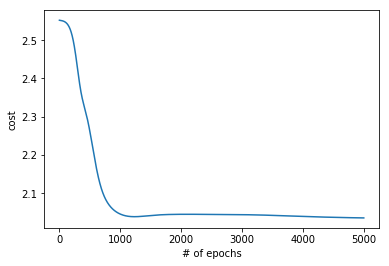

In [29]:
%load_ext autoreload
%autoreload 2
import numpy as np
from tqdm import tqdm_notebook
import re
from matplotlib import pyplot as plt
paras = skipgram_model_training(X, Y_one_hot, vocab_size, 50, 0.05, 5000, batch_size=128, parameters=None, print_cost=True)

## Evaluation
After train the model with data generated from the example sentence above with a window size of 3 for 5000 epochs (with a simple learning rate decay), we can see the model can output most neighboring words given each word as an input word.

In [27]:
X_test = np.arange(vocab_size)
X_test = np.expand_dims(X_test, axis=0)
softmax_test, _ = forward_propagation(X_test, paras)
top_sorted_inds = np.argsort(softmax_test, axis=0)[-4:,:]

In [28]:
for input_ind in range(vocab_size):
    input_word = id_to_word[input_ind]
    output_words = [id_to_word[output_ind] for output_ind in top_sorted_inds[::-1, input_ind]]
    print("{}'s neighbor words: {}".format(input_word, output_words))

of's neighbor words: ['the', 'of', 'costs', 'beating']
investing's neighbor words: ['the', 'stock', 'beating', "loser's"]
stock's neighbor words: ['investing', 'a', 'is', 'market']
game's neighbor words: ['is', "loser's", 'a', 'beating']
a's neighbor words: ['game', 'market', "loser's", 'stock']
the's neighbor words: ['is', 'of', 'beating', 'stock']
beating's neighbor words: ['market', 'stock', 'investing', 'costs']
is's neighbor words: ['game', 'market', "loser's", 'stock']
loser's's neighbor words: ['game', 'market', "loser's", 'stock']
after's neighbor words: ['of', 'the', 'deduction', 'costs']
costs's neighbor words: ['beating', 'of', 'deduction', 'the']
market's neighbor words: ['is', "loser's", 'a', 'beating']
deduction's neighbor words: ['costs', 'after', 'the', 'beating']


## Optimization (Space)
When I tried to train the model above with a larger dataset, I found the memory consumption kept increasing during the training process and the python kernel finally shut down. Later on, I figured out the issue had to do with the way I fed the labels Y into the model.

In the original code, each label is a one hot vector which used a bunch of zeros and a single one to represent the labeled output word. When the vocabulary size grows bigger, we waste so much memory to the zeros that do not provide us useful information.

The memory consumption problem goes away after I start to feed the label with its associated word ind only. We have decreased the space from O(vocabulary size * m) to O(m).

The following is my code implementation (There are only 2 places needed to be changed):

In [12]:
def cross_entropy(softmax_out, Y):
    """
    softmax_out: output out of softmax. shape: (vocab_size, m)
    """
    m = softmax_out.shape[1]
    cost = -(1 / m) * np.sum(np.log(softmax_out[Y.flatten(), np.arange(Y.shape[1])] + 0.001))
    return cost
  

def softmax_backward(Y, softmax_out):
    """
    Y: labels of training data. shape: (vocab_size, m)
    softmax_out: output out of softmax. shape: (vocab_size, m)
    """
    m = Y.shape[1]
    softmax_out[Y.flatten(), np.arange(m)] -= 1.0
    dL_dZ = softmax_out
    
    assert(dL_dZ.shape == softmax_out.shape)
    return dL_dZ